## Homography and Projective Transformations Example

Source: https://towardsdatascience.com/image-processing-with-python-applying-homography-for-image-warping-84cd87d2108f

#### Let's first download all the necessary libraries and modules required for this notebook.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle
from skimage import transform
from skimage.io import imread

### Let's load an example from the provided images folder.

Ideally, we would want to load in an image that is oriented in a non-uniform manner (i.e. image taken from a slanted angle). By doing so, we can try to retain the image structure, just from a different perspective/angle.

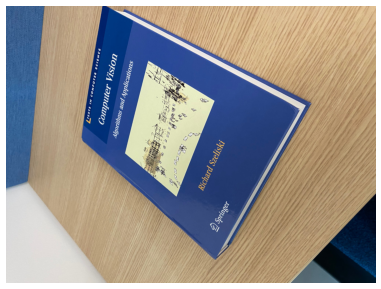

In [8]:
# Read in the image path
book_img = imread('images/book.jpg')

# Display the image
plt.figure(figsize=(8, 6), dpi=60)
plt.imshow(book_img)
plt.axis('off')
plt.show()

### We will use the imported transform function to rotate our image.

We are using Python-imported functions to get a sense of how these image transformations work. Ideally, we would want to build our own Homography matrices to transform the image from one plane to another in 2D -> 3D -> 2D space.

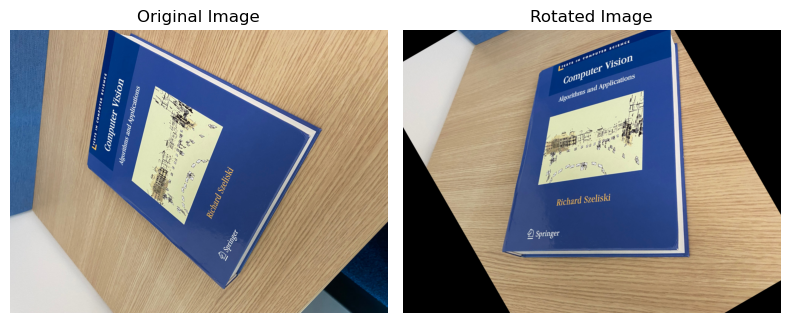

In [9]:
# The book is already rotated, so let's try to make it look upright
book_rotate = transform.rotate(book_img, -60)

# Plot the original and rotated images
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
axes[0].imshow(book_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(book_rotate)
axes[1].set_title('Rotated Image')
axes[1].axis('off')

# Better spacing between images
fig.tight_layout()

plt.show()

### We can see that there are blank spaces around the rotated image. We want to fill in these blank spaces to make the image look more natural. 

These blank spaces are normal since we did not create any new information using the pixels (points in our image) we were given. Hence, the rest of the space are defaulted to having no color (i.e. blank spaces).

We can create a function that fills in the rotated blank spaces. In essence, we want to use the pixels that we have leftover (after the transformation) to create new information that helps us fill in the blank spaces.

A way we can do this is to use the different modes of transformations that are also imported from the `Skimage` Python library.

The different modes are `constant`, `edge`, `symmetric`, `reflect`, and `wrap` as shown in the code cell below. Each mode has different ways of filling in these blank spaces. It is up to the user to decide which one best suits the transformed image.

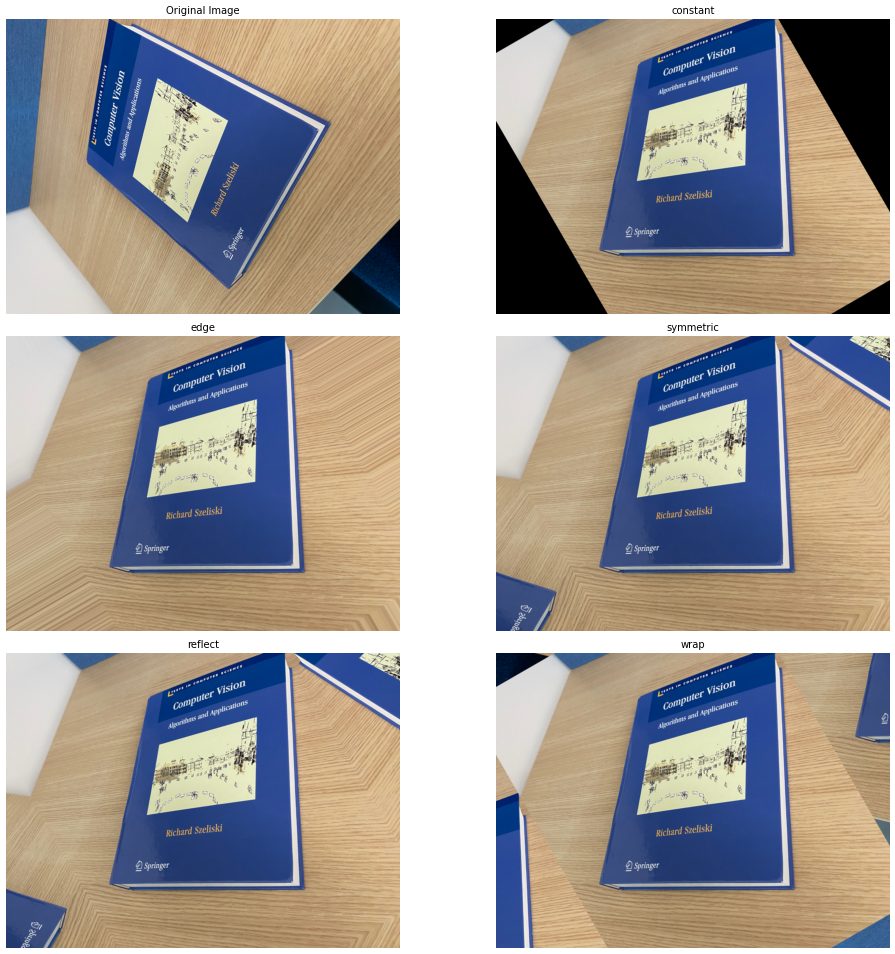

In [10]:
# Now, let us try to fill in the blank spaces
def rotate_fills(image):
    modes = ['constant', 'edge', 'symmetric', 'reflect', 'wrap']        # Different modes of image transformations
    fig, ax = plt.subplots(3, 2, figsize=(18, 16), dpi=60)

    # Plot the effects of applying the different modes of transformations
    for i, axis in enumerate(ax.flatten()):
        if i == 0:
            axis.set_title("Original Image")
            axis.imshow(image)

        else:
            axis.set_title(f'{modes[i - 1]}')
            transformed_image = transform.rotate(image, -60, mode = modes[i - 1])
            axis.imshow(transformed_image)
        
        axis.axis('off')
    
    fig.tight_layout()


rotate_fills(book_img)

### We have seen each of the different transformation modes for rotation. However, the image does not look realistic in any of the images above. Perhaps there is a better method...? Let's try using warping instead!

Warping involves more computational complexity than rotation. In particular, we need to find the points of interest in the original image and "link" them to the desired points of interest of our transformed object. 

Note that the points below are manually selected by the user. There is no direct way of addressing these points in a simpler fashion.

### Our plan here is to obtain the points of interest from our input image. Then, we want to orient those same points to a new coordinate plane for the object of interest (i.e. a book). A visualization of this is shown below.

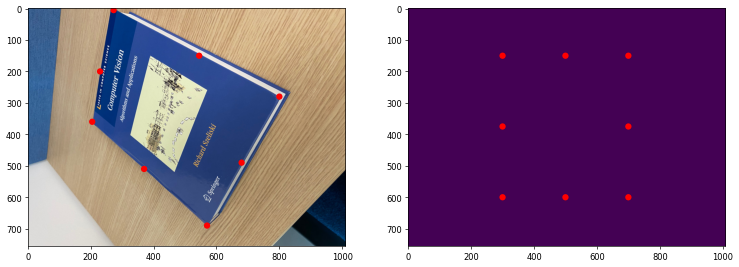

In [11]:
# Entire book
points_of_interest = np.array([[205, 360],
                               [230, 200],
                               [273, 5],
                               [370, 510],
                               [570, 690],
                               [680, 490],
                               [800, 280],
                               [545, 150]])

points_of_projection = np.array([[300, 150],
                                 [500, 150],
                                 [700, 150],
                                 [300, 375],
                                 [300, 600],
                                 [500, 600],
                                 [700, 600],
                                 [700, 375]])


# Book Cover Logo
# points_of_interest = np.array([[325, 400],
#                                [355, 280],
#                                [390, 150],
#                                [465, 520],
#                                [518, 390],
#                                [570, 260]])

# points_of_projection = np.array([[350, 250],
#                                  [500, 250],
#                                  [650, 250],
#                                  [350, 450],
#                                  [500, 450],
#                                  [650, 450]])


color = 'red'
fig, ax = plt.subplots(1, 2, figsize=(15, 20), dpi=60)

# Obtain our points at the corners of our object of interest
for i in range(len(points_of_interest)):
    point_original = Circle((points_of_interest[i][0], points_of_interest[i][1]), 10, facecolor=color)
    point_projection = Circle((points_of_projection[i][0], points_of_projection[i][1]), 10, facecolor=color)

    ax[0].add_patch(point_original)
    ax[1].add_patch(point_projection)

ax[0].imshow(book_img)

# Create a blank image with our desired point placements
blank_img = np.ones((book_img.shape[0], book_img.shape[1]))
ax[1].imshow(blank_img)

### Now, we have a general visualization of where we want our object to be placed. We can apply projective transformations to move the object from the input space to this new coordinate plane.

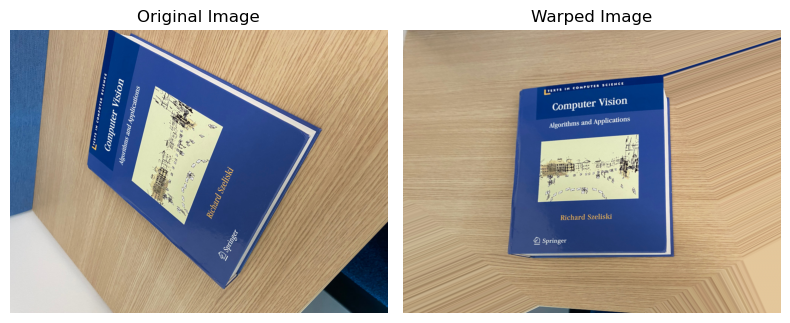

In [12]:
# Imported projective transformation using our points of interest (and projection)
projective_transform = transform.estimate_transform('projective', points_of_interest, points_of_projection)

# modes = ['constant', 'edge', 'symmetric', 'reflect', 'wrap']
img_warp = transform.warp(book_img, projective_transform.inverse, mode = 'edge')        # 'edge' mode seems to work the best, although not great

# Plot the original and warped images
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
axes[0].imshow(book_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_warp)
axes[1].set_title('Warped Image')
axes[1].axis('off')

# Better spacing
fig.tight_layout()

plt.show()

### As shown, we have moved our book to the new position that we specified above.

This transformation is an estimate of what the real image can look like. We can see that there are a few defects in the projective transformation -- aka the book is still slightly slanted and the edges are not filled in correctly. 

We applied each of the different modes of image transformation to account for the blank spaces in the transformed image, but it seems that `edge` seems to work the best. Even with this `edge` mode, the image doesn't look particularly realistic.

Why?

The initial input image doesn't have much space around the corners of the book, making it difficult for our estimate to account for this tightness. In other words, since the edges/corners of the object are close to the frame of the image, applying realistic transformations is a difficult task.

Additionally, we have lost some pixels (i.e. points in our input space) due to our transformation. Hence, we had to make estimates about which points would help us fill in the blank spaces that were created; in other words, we created new information that is not guaranteed to be accurate.

#### So far, we have gone through a simple example of how projective transformations work using ``homographies``. 

This is a good starter notebook to get a basic sense of how these transformations can be applied in different types of input images. 

We are now ready to dive deeper. The ``transformations`` notebook in the same directory provides an in-depth analysis on how we can create our own homographies, including what is going on under the hood of many of the functions we provided above. 

We can also get a sense of how these transformations are used in the real world and why they are important for a plethora of computer vision tasks.